# Step5. Visualization

### 5.1 Load the model and replace to transcoder layers

In [ ]:
from transformer_lens import HookedTransformer, HookedTransformerConfig
from dataclasses import dataclass
import torch
import os
import sys
from abc import ABC
import json
import pickle
from transformers import PreTrainedTokenizerFast
from utils import MyIterableDataset, build_cfg

sys.path.append('../')
from circuit_tracer.configs import Configs
from circuit_tracer.replacement_model import ReplacementModel




n = 10
pattern_name = f'sync{n}'
method = 'path'
n_layer = 5
density = 0.8
edge_remove_density = 0.4
d_hid = 128 # 1536# 768# 192
n_hid = 12

## set GPU
cuda_range = [1]
cuda_list = [f'cuda:{i}' for i in cuda_range]
split_layer = int(n_layer/len(cuda_range))

plan = []
for s, cuda_id in enumerate(cuda_range):
    end = (s + 1)*split_layer
    if end>n_layer:
        end = n_layer
    plan.append((torch.device(f'cuda:{cuda_id}'),range(s*split_layer,end)))

device_map = {}
for dev, layers in plan:
    for L in layers:
        device_map[L] = dev


acts_func = 'relu'
transcoder_save_path = f'/egr/research-dselab/shared/transcoder_model/{acts_func}_{pattern_name}_{method}_{n_layer}_{d_hid}'
base_path=f'/egr/research-dselab/shared/daixinna/graph_reasoning/baby_models'
config_path = os.path.join(os.path.join(base_path,'transcoder_configs.json'))

configs = Configs.init_load(config_path)
configs.set_device_map(device_map)

dataset_path = os.path.join(base_path,'datasets')
tokenizer_path = os.path.join(dataset_path, f"{pattern_name}_{method}_baby_tokenizer.json")
out_dir = os.path.join(base_path, f"models/{pattern_name}_{method}_{n_layer}")
model_path = os.path.join(out_dir, f"{n_layer}_{d_hid}_model_weights.pt")


tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
transcoder_cache_dir = os.path.join(configs.checkpoint_path, f"{configs.dead_feature_window}_{configs.l1_coefficient}",'configs.json')
transcoder = os.path.join(configs.checkpoint_path, f"{configs.dead_feature_window}_{configs.l1_coefficient}")

configs_save_path = os.path.join(base_path,f'baby_{pattern_name}_{method}_{n_layer}_{d_hid}_configs.json')
with open(configs_save_path, "r") as f:
    base_model_configs = json.load(f)

base_cfg = build_cfg(base_model_configs)
print(model_path)

model = ReplacementModel.from_self_pretrained_and_transcoders( model_name='sync', model_path=model_path, transcoders_path=transcoder, cfg=configs, base_cfg=base_cfg)
model.tokenizer = tokenizer
model.forward = model.forward_sharded
model.set_device_map(device_map)
model.eval()

/egr/research-dselab/shared/daixinna/graph_reasoning/baby_models/models/sync10_path_5/5_128_model_weights.pt
Moving model to device:  cpu


ReplacementModel(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-4): 5 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): ReplacementMLP(
        (old_mlp): MLP(
          (hook_pre): HookPoint()
          (hook_post): HookPoint()
        )
        (hook_in): HookPoint()
        (hook_out): HookPoint(
          (hook_out_grad): HookPoint()
        )
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_inp

# Step5.2 Run attribution graph generation code
(code is based on [circuit-tracer](https://github.com/safety-research/circuit-tracer/tree/main))

In [ ]:
import sys
sys.path.append('../')
from circuit_tracer import attribute
from circuit_tracer.utils import create_graph_files
from circuit_tracer.frontend.graph_models import Metadata, Model, Node, QParams
from circuit_tracer.frontend.utils import add_graph_metadata, process_token
from circuit_tracer.graph import Graph, prune_graph
from circuit_tracer.utils.create_graph_files import create_nodes, create_used_nodes_and_edges

prompt = '<START> 0 8 | 1 3 | 1 5 | 3 0 | 4 5 | 4 2 | 5 7 | 5 0 | 5 1 | 8 5 | 8 2 | 9 6 | 9 5 S 3 E 5 PATH 3'# 0 8 5 END_P <END>'
max_n_logits = 10   # How many logits to attribute from, max. 
desired_logit_prob = 0.95  # Attribution will attribute from the minimum number of logits needed to reach this probability mass (or max_n_logits, whichever is lower)
max_feature_nodes = 2048  # Only attribute from this number of feature nodes, max. Lower is faster, but you will lose more of the graph. None means no limit.
batch_size=256
offload = 'cpu'# 'disk' if IN_COLAB else 'cpu' # Offload various parts of the model during attribution to save memory. Can be 'disk', 'cpu', or None (keep on GPU)
verbose = True 
graph = attribute(
    prompt=prompt,
    model=model,
    input_ids=None,
    max_n_logits=max_n_logits,
    desired_logit_prob=desired_logit_prob,
    batch_size=batch_size,
    max_feature_nodes=max_feature_nodes,
    offload=offload,
    verbose=verbose
)


Phase 0: Precomputing activations and vectors
Precomputation completed in 0.11s
Found 1486 active features
Phase 1: Running forward pass
Forward pass completed in 0.01s
Phase 2: Building input vectors
Selected 2 logits with cumulative probability 0.9617
Will include 1486 of 1486 feature nodes
Input vectors built in 0.02s
Phase 3: Computing logit attributions
Logit attributions completed in 0.03s
Phase 4: Computing feature attributions
Feature influence computation: 100%|██████████| 1486/1486 [00:00<00:00, 10721.34it/s]
Feature attributions completed in 0.14s
Attribution completed in 0.33s


### Step5.3. Write your own visualization method

(Here is just an example)

In [ ]:
def plot_connections_with_token_labels_graph_recover(connections, tokens):
    import matplotlib.pyplot as plt

    # Build y-axis mapping
    layer_to_y = {"Emb": 0,'logit': n_layer+1}
    for conn in connections:
        src_layer = conn[1]
        tgt_layer = conn[4]
        if src_layer != "Emb":
            layer_to_y[int(src_layer)] = int(src_layer) + 1
        if tgt_layer != 'logit':
            layer_to_y[int(tgt_layer)] = int(tgt_layer) + 1
    # Plot connections
    all_names = set()
    for src_name, *_ , tgt_name, _, _ in connections:
        all_names.add(src_name)
        all_names.add(tgt_name)
    all_names = sorted(list(all_names))
    name_offset = {name: i * 0.2 - 0.2 * (len(all_names) - 1) / 2 for i, name in enumerate(all_names)}

    fig, ax = plt.subplots(figsize=(15, 6))
    # print(connections)
    for src_name, src_layer, src_pos, tgt_name, tgt_layer, tgt_pos in connections:
        y1 = layer_to_y[src_layer] if src_layer == "Emb" else layer_to_y[int(src_layer)]
        y2 = layer_to_y[tgt_layer] if tgt_layer == 'logit' else layer_to_y[int(tgt_layer)]

        offset1 = name_offset.get(src_name, 0.0)
        offset2 = name_offset.get(tgt_name, 0.0)
        
        if tgt_layer == 'logit':
            x1 = int(src_pos)
            x2 = int(tgt_pos) + offset2            
        else:
            x1 = int(src_pos) # + offset1
            x2 = int(tgt_pos) # + offset2

        ax.plot([x1, x2], [y1, y2], marker='o', color='gray', alpha=0.6)

        ax.text(x1, y1, src_name, fontsize=16, ha='right', va='center')
        if tgt_layer == 'logit':
            ax.text(x2, y2, tgt_name, fontsize=16, ha='left', va='center')

        # Label tokens at embedding layer
        for pos, token in enumerate(tokens):
            ax.text(pos, layer_to_y["Emb"] - 0.3, token, ha='center', va='top', fontsize=9, rotation=45)

# Step5.4 Visualiazation the attribution graph on the single sample
(Here is an interpretation of why next token prediction is 0)

1 7 0 cross layer transcoder
1 7 0 cross layer transcoder
5 8 0 cross layer transcoder
3 10 0 cross layer transcoder
3 10 0 cross layer transcoder
3 10 0 cross layer transcoder
0 11 0 cross layer transcoder
0 11 0 cross layer transcoder
0 11 0 cross layer transcoder
0 11 0 cross layer transcoder
0 11 0 cross layer transcoder
0 11 0 cross layer transcoder
0 11 0 cross layer transcoder
0 11 0 cross layer transcoder
0 11 0 cross layer transcoder
S 39 0 cross layer transcoder
S 39 0 cross layer transcoder
S 39 0 cross layer transcoder
E 41 0 cross layer transcoder
E 41 0 cross layer transcoder
5 42 0 cross layer transcoder
5 42 0 cross layer transcoder
5 42 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
3 44 0 cross layer transcoder
0 11 1 cross 

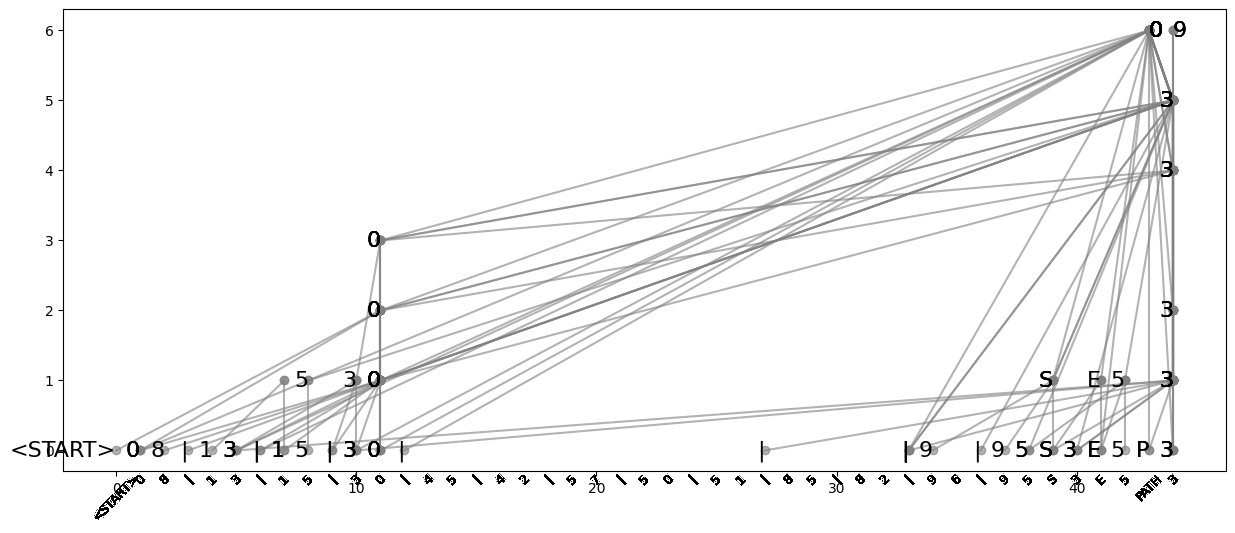

In [ ]:
node_threshold=0.6
edge_threshold=0.8# 0.99# 0.99

node_mask, edge_mask, cumulative_scores = (
    el.cpu() for el in prune_graph(graph, node_threshold, edge_threshold)
)
nonzero_indices = torch.nonzero(node_mask)

scan = graph.scan
nodes = create_nodes(graph, node_mask, tokenizer, cumulative_scores, scan)
used_nodes, used_edges = create_used_nodes_and_edges(graph, nodes, edge_mask)
nodes_dicts = {}

def translate_node_ids(node_id, given_type):
    node_id = node_id.split('_')
    if given_type == 'embedding':
        vocab_id = int(node_id[1])
        pos = int(node_id[2])
        id = tokenizer.decode(vocab_id)
        layer = 'Emb'
    if given_type == "mlp reconstruction error":
        _, layer, pos = int(node_id[0]), int(node_id[1]), int(node_id[2])
        id = 'block_inner'
    if given_type == "logit":
        layer, vocab_id, pos = int(node_id[0]), int(node_id[1]), int(node_id[2])
        layer = 'logit'
        id = tokenizer.decode(vocab_id)
    if given_type == "cross layer transcoder":
        layer, feat_idx, pos = int(node_id[0]), int(node_id[1]), int(node_id[2])
        id = tokenizer.decode(graph.input_tokens[pos])
    return id, pos, layer

for n in used_nodes:
    nodes_dicts[n.node_id] = {}
    nodes_dicts[n.node_id]['features'] = n.feature_type
    nodes_dicts[n.node_id]['clerp'] = n.clerp
connections = []
tokens = prompt.split()
for e in used_edges:
    if nodes_dicts[e['source']]['features'] == "mlp reconstruction error": continue
    if nodes_dicts[e['target']]['features'] == "mlp reconstruction error": continue
    weights = e['weight']
    if weights<0.:continue
    source_node, source_pos, source_layer = translate_node_ids(e['source'], nodes_dicts[e['source']]['features'])
    target_node, target_pos, target_layer = translate_node_ids(e['target'], nodes_dicts[e['target']]['features'])
    print(target_node, target_pos, target_layer, nodes_dicts[e['target']]['features'])
    if source_node == 'PATH': source_node = 'P'
    if target_node == 'PATH': target_node = 'P'
    connections.append((source_node, source_layer, source_pos, target_node, target_layer, target_pos))
    

plot_connections_with_token_labels_graph_recover(connections, tokens)